# CSCK506 - Deep Learning

## Import libraries


In [ ]:
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Concatenate, Activation, ZeroPadding2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers import BatchNormalization
from keras.optimizers import adam_v2
from keras.optimizers import gradient_descent_v2
from keras.utils.vis_utils import plot_model


from sklearn.metrics import classification_report,confusion_matrix


import cv2
import os

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Import, visualize and manipulate Data

### Define some initial parameters

In [ ]:
data_dir = '/content/drive/MyDrive/MSc_Liverpool_University_AI/CSCK506/week08/group_activity/dataset/chest_xray/'
train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')
val_data_dir = os.path.join(data_dir, 'val')

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

In [ ]:
def get_data(data_dir, labels, img_size):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### Get the train, test and validation data using 'get_data'

In [ ]:
train_set = get_data(train_data_dir, labels, img_size)
test_set = get_data(test_data_dir, labels, img_size)
val_set = get_data(val_data_dir, labels, img_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


### Split the datasets into x and y (independent and dependent variables, respectively)

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_set:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_set:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val_set:
    x_val.append(feature)
    y_val.append(label)

### Visualize the data

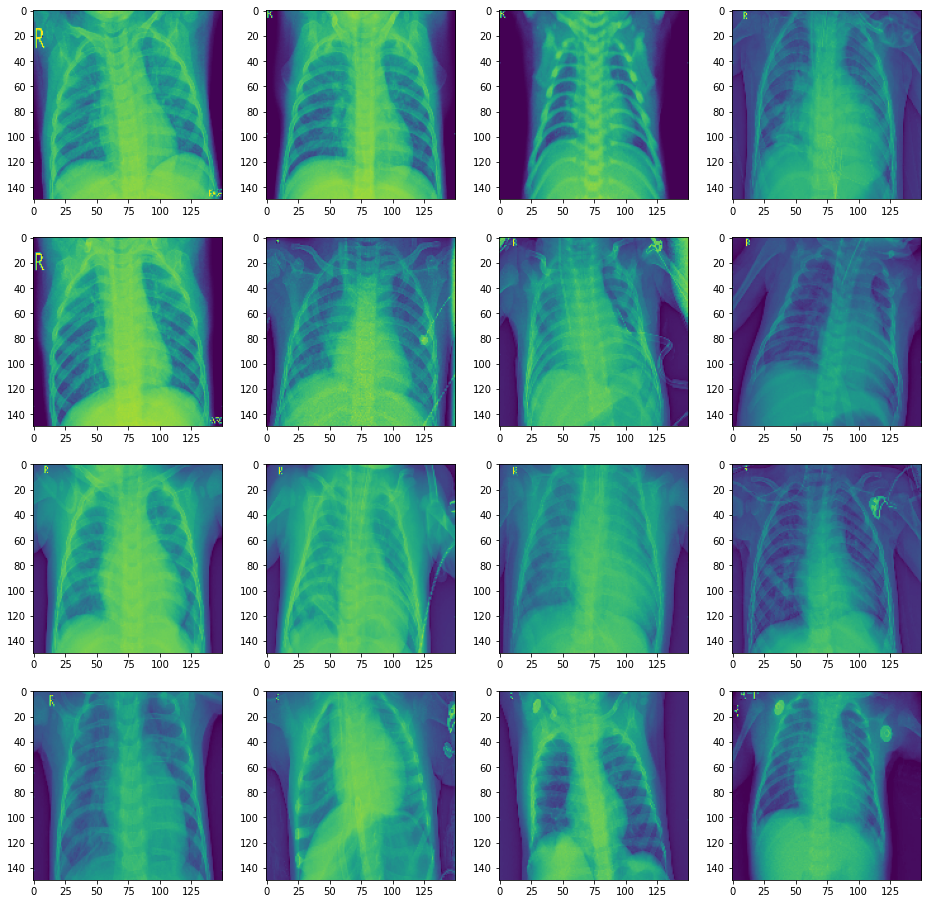

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i])

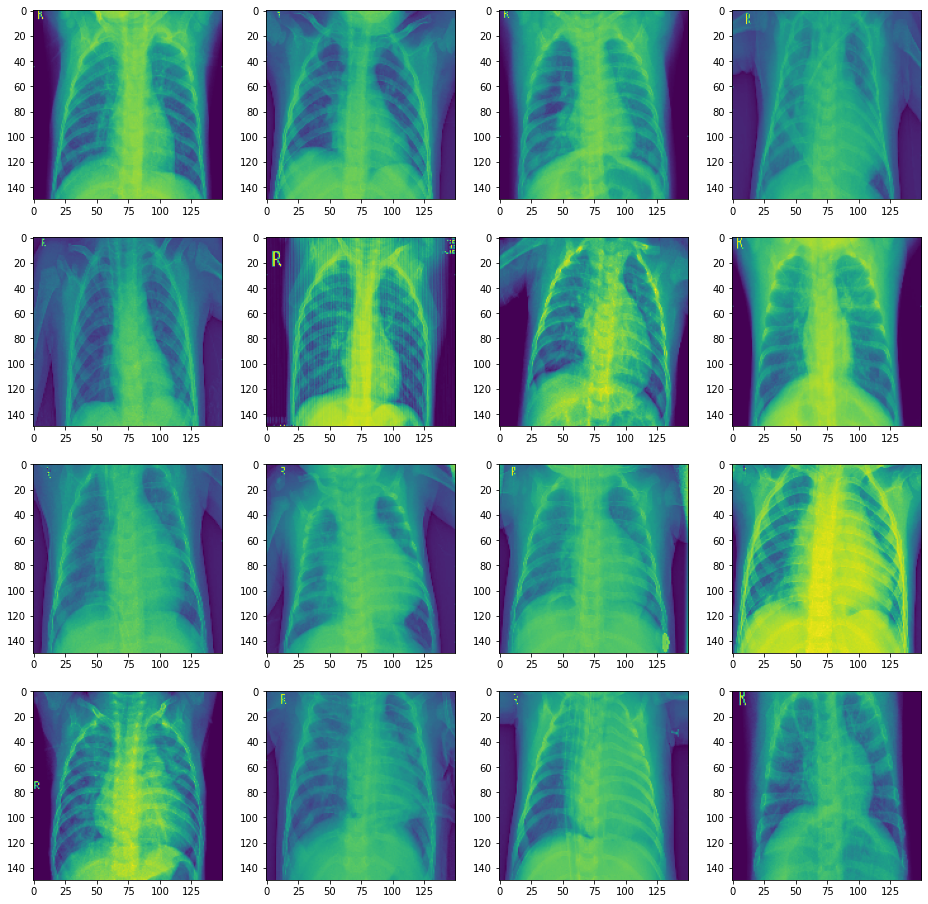

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i])

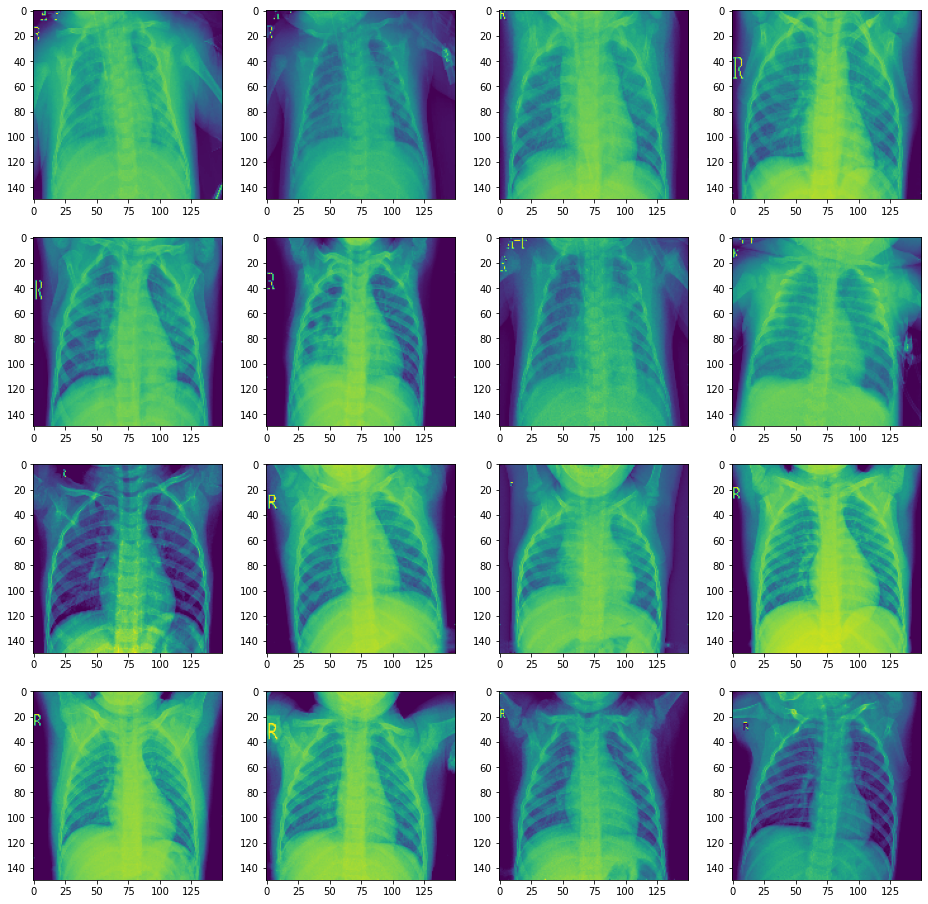

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_val[i])

### Normalize the data

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

### Resize the data

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Model

### Build the model

In [ ]:
def FireModule(s_1x1, e_1x1, e_3x3, name):

    def layer(x):
        squeeze = Conv2D(s_1x1, 1, activation='relu', kernel_initializer='he_normal', name=name+'_squeeze')(x)
        squeeze = BatchNormalization(name=name+'_squeeze_bn')(squeeze)

        expand_1x1 = Conv2D(e_1x1, 1, padding='same', activation='relu', kernel_initializer='he_normal', name=name+'_expand_1x1')(squeeze)

        expand_3x3 = Conv2D(e_3x3, 3, padding='same', activation='relu', kernel_initializer='he_normal', name=name+'_expand_3x3')(squeeze)

        expand_merge = Concatenate(axis=3, name=name+'_expand_merge')([expand_1x1, expand_3x3])
        return expand_merge

    return layer

In [ ]:
def SqueezeNet(nb_classes=1, input_shape=(img_size,img_size,1)): 

    input_image = Input(shape=input_shape)
    conv1 = Conv2D(96, 7, 2, activation='relu', kernel_initializer='he_normal', name='conv1')(input_image)
    maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool1')(conv1)
    fire2 = FireModule(s_1x1=16, e_1x1=64, e_3x3=64, name='fire2')(maxpool1)
    fire3 = FireModule(s_1x1=16, e_1x1=64, e_3x3=64, name='fire3')(fire2)
    fire4 = FireModule(s_1x1=32, e_1x1=128, e_3x3=128, name='fire4')(fire3)
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool4')(fire4)
    fire5 = FireModule(s_1x1=32, e_1x1=128, e_3x3=128, name='fire5')(maxpool4)
    fire6 = FireModule(s_1x1=48, e_1x1=192, e_3x3=192, name='fire6')(fire5)
    fire7 = FireModule(s_1x1=48, e_1x1=192, e_3x3=192, name='fire7')(fire6)
    fire8 = FireModule(s_1x1=64, e_1x1=256, e_3x3=256, name='fire8')(fire7)
    maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool8')(fire7)
    fire9 = FireModule(s_1x1=64, e_1x1=256, e_3x3=256, name='fire9')(maxpool8)
    fire9_dropout = Dropout(rate=0.5, name='fire9_dropout')(fire9)
    conv10 = Conv2D(nb_classes, 1, activation='relu', kernel_initializer='he_normal', name='conv10')(fire9_dropout)
    conv10 = BatchNormalization(name='conv10_bn')(conv10)
    avgpool10 = GlobalAveragePooling2D(name='avgpool10')(conv10)
    sigmoid = Activation('sigmoid', name='sigmoid')(avgpool10)
    model = Model(inputs=input_image, outputs=[sigmoid])
    return model

In [ ]:
model = SqueezeNet()

### Display the model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 72, 72, 96)   4800        ['input_1[0][0]']                
                                                                                                  
 maxpool1 (MaxPooling2D)        (None, 35, 35, 96)   0           ['conv1[0][0]']                  
                                                                                                  
 fire2_squeeze (Conv2D)         (None, 35, 35, 16)   1552        ['maxpool1[0][0]']           

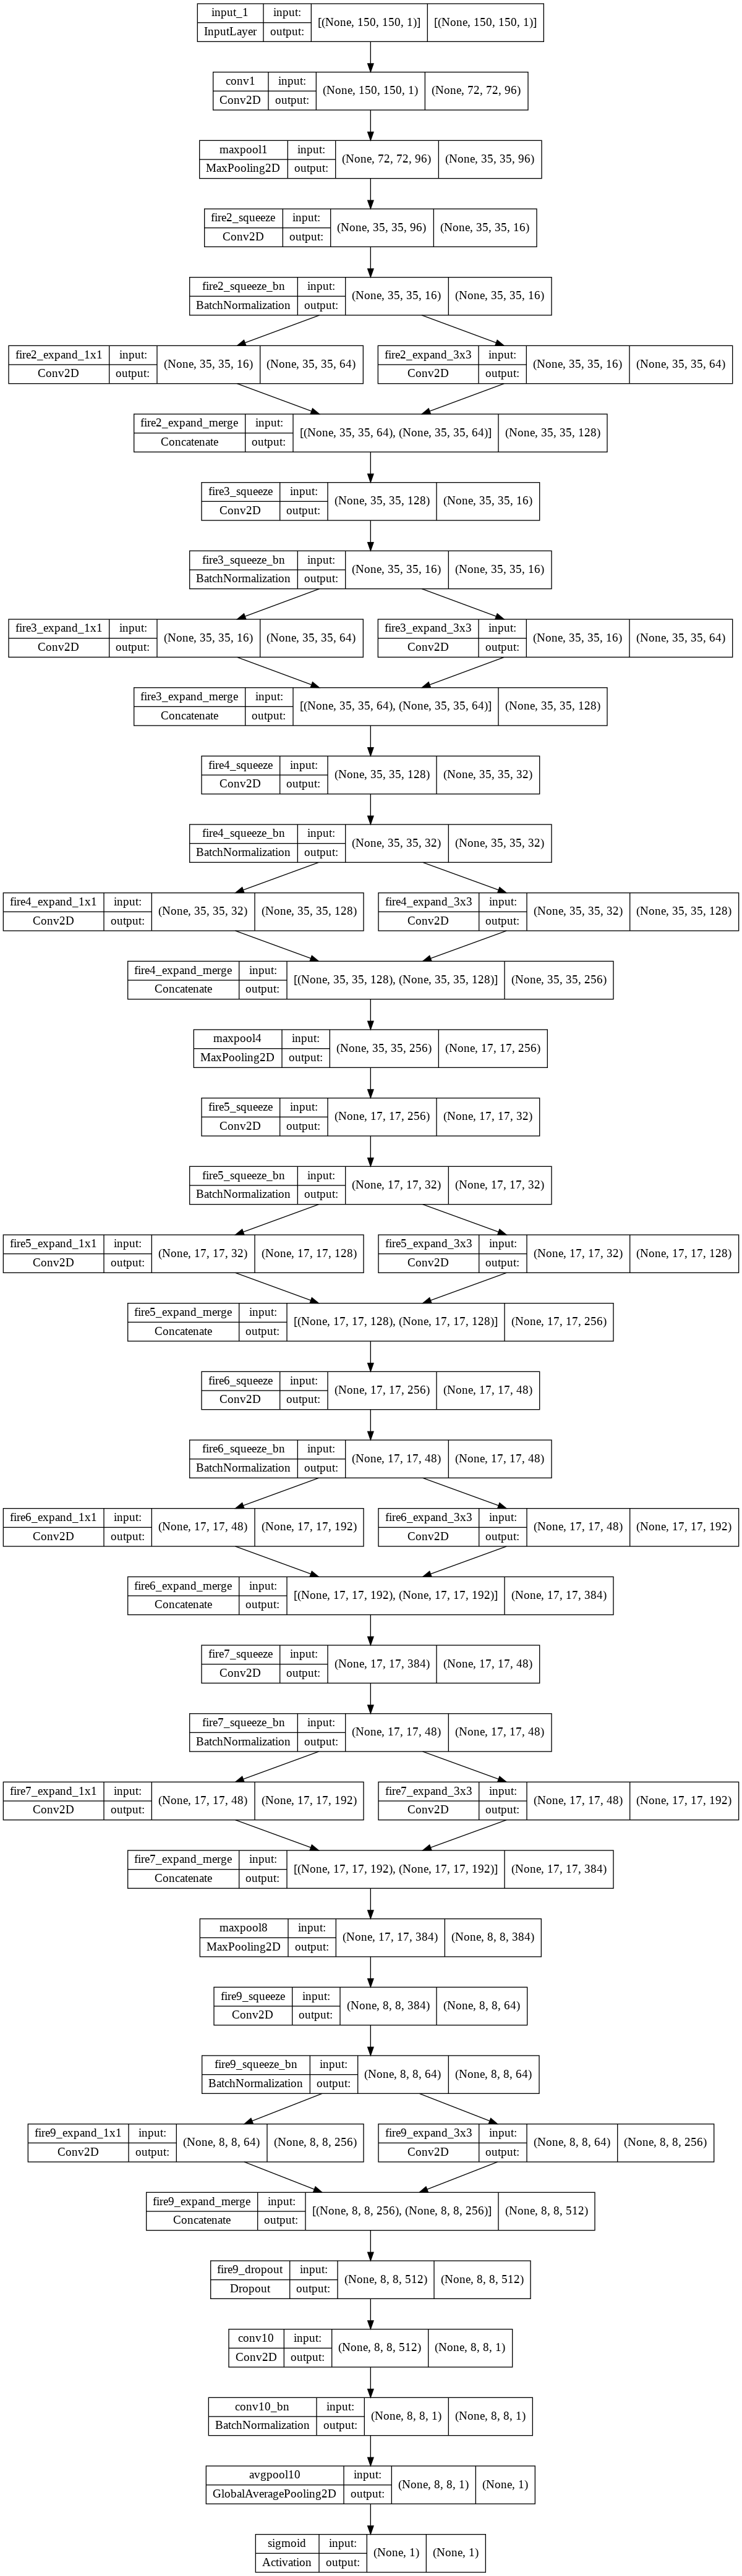

In [ ]:
plot_model(model, to_file='squeezenet.png', show_shapes=True, show_layer_names=True)

### Export model

In [ ]:
model.save('/content/drive/MyDrive/MSc_Liverpool_University_AI/CSCK506/week08/group_activity/models/squeezenet.h5')

### Compile the model

In [ ]:
adam = adam_v2.Adam(learning_rate=0.040)
#sgd = gradient_descent_v2.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
loss="binary_crossentropy"
metrics=['accuracy']

In [ ]:
model.compile(loss=loss, optimizer=adam, metrics=metrics)

### Train the model

In [ ]:
batch_size = 32
epochs = 10

In [ ]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/10
164/164 [==============================] - 14s 85ms/step - loss: 0.0835 - accuracy: 0.9699 - val_loss: 2.4689 - val_accuracy: 0.6250
Epoch 2/10
164/164 [==============================] - 13s 82ms/step - loss: 0.0860 - accuracy: 0.9681 - val_loss: 0.5488 - val_accuracy: 0.8125
Epoch 3/10
164/164 [==============================] - 13s 82ms/step - loss: 0.0700 - accuracy: 0.9752 - val_loss: 1.5912 - val_accuracy: 0.5000
Epoch 4/10
164/164 [==============================] - 13s 82ms/step - loss: 0.0783 - accuracy: 0.9700 - val_loss: 1.6263 - val_accuracy: 0.5000
Epoch 5/10
164/164 [==============================] - 13s 82ms/step - loss: 0.0778 - accuracy: 0.9723 - val_loss: 0.7459 - val_accuracy: 0.7500
Epoch 6/10
164/164 [==============================] - 13s 82ms/step - loss: 0.0699 - accuracy: 0.9739 - val_loss: 2.1059 - val_accuracy: 0.5625
Epoch 7/10
164/164 [==============================] - 13s 82ms/step - loss: 0.0687 - accuracy: 0.9748 - val_loss: 1.0153 - val_accuracy:

## Results Analysis

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 27ms/step - loss: 0.5478 - accuracy: 0.8157
Loss of the model is -  0.5478001832962036
20/20 [==============================] - 1s 28ms/step - loss: 0.5478 - accuracy: 0.8157
Accuracy of the model is -  81.57051205635071 %


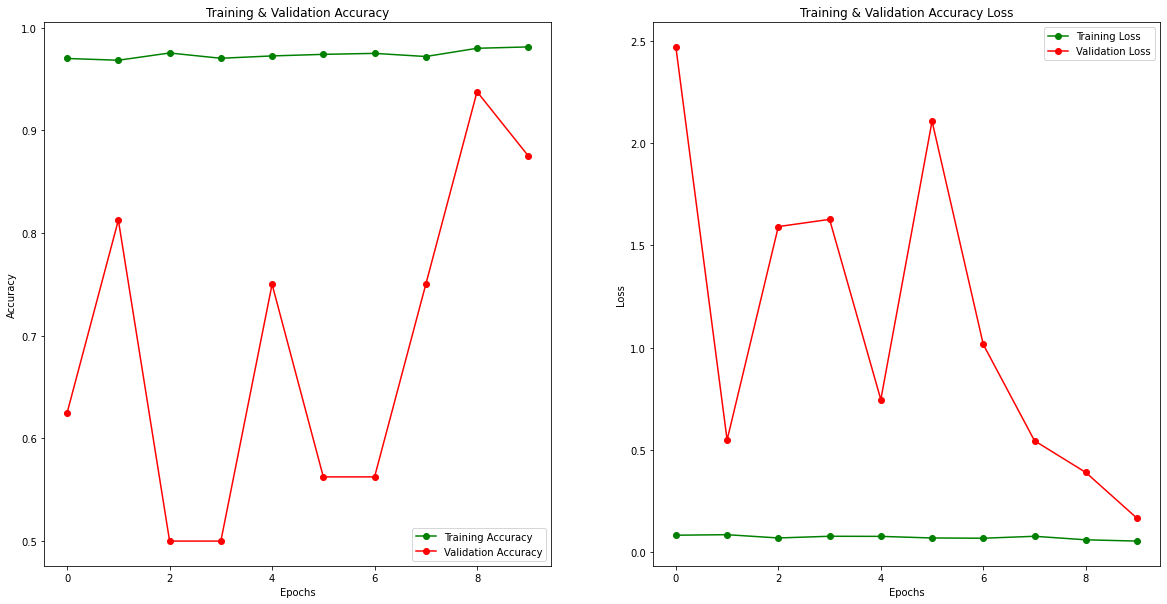

In [ ]:
epochs_range = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs_range , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs_range , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs_range , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs_range , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Accuracy Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = np.round_(model.predict(x_test))
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.81      0.93      0.86       390
   Normal (Class 1)       0.84      0.63      0.72       234

           accuracy                           0.82       624
          macro avg       0.82      0.78      0.79       624
       weighted avg       0.82      0.82      0.81       624



In [ ]:
confusion_matrix(y_test,predictions)

array([[362,  28],
       [ 87, 147]])